<a href="https://colab.research.google.com/github/tcmle/CS-Notes/blob/master/News_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2022-02-10 10:23:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.08s   

2022-02-10 10:23:55 (60.9 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
ls sample_data/

anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*


In [6]:
!cat /tmp/bbc-text.csv -n 10

     1	category,text
     2	tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
vocab_size = 10000
embedding_dim = 32
max_length =120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_portion = .8

In [8]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
print("is" in stopwords)
# Expected Output
# 153

153
True


In [9]:
df=pd.read_csv("/tmp/bbc-text.csv")
print(df.head())

print(set(df.category))

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
{'tech', 'business', 'entertainment', 'politics', 'sport'}


In [10]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [11]:
df.shape

(2225, 2)

In [12]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [14]:
df =  df.sample(frac=1.0)

In [15]:
df.head()

,category,text
378,tech,parents face video game lessons ways of ensuri...
385,politics,ukip s secret weapon by any measure new york...
156,sport,lomu relishing return to action former all bla...
1047,entertainment,uk directors guild nominees named martin scors...
76,business,yukos sues four firms for $20bn russian oil fi...


In [16]:
train_size = int(int(df.shape[0])*training_portion)

train_sentences = list(df['text'][0:train_size])
train_labels = list(df['category'][0:train_size])

validation_sentences = list(df['text'][train_size:])
validation_labels = list(df['category'][train_size:])

#Q1: how to make sure the class ratio is equal between train and test?
# Q2: does the class ratio between train and test matter? why?

#Comments: the effecientcy of below method to remove stop words?
#Q3: What will be a better way to do this?

In [17]:
#Remove Stop Words and create revised train_Sentences list
train_sentences_final=[]
for sentence in train_sentences:
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  train_sentences_final.append(sentence)
  

print(len(train_sentences_final))

validation_sentences_final=[]
for sentence in validation_sentences:
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  validation_sentences_final.append(sentence)

print(len(validation_sentences_final))

1780
445


In [18]:
tokenizer = Tokenizer(oov_token='<oov>',num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences_final)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences_final)
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences_final)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

training_label_seq = np.array(training_label_seq)
validation_label_seq=np.array(validation_label_seq)

In [20]:
num_epochs = 10
with tf.device('/device:GPU:0'):

  model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(units=24,activation='relu'),
                              tf.keras.layers.Dense(units=6,activation='softmax')
                              

  ])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()

  history = model.fit(train_padded,training_label_seq,epochs=num_epochs,validation_data=(validation_padded,validation_label_seq),verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 320,942
Trainable params: 320,942
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
56/56 - 1s - loss: 1.7573 - accuracy: 0.2399 - val_loss: 1.7025 - val_accuracy: 0.4337 - 1s/epoch - 20ms/

In [21]:
model.save("simple_model.h5")

In [22]:
ls

sample_data/  simple_model.h5


In [23]:
test_str1="""
For gainful and productive employment growth of this magnitude, India's GDP will need to grow by 8- 8.5 per cent annually over 2023-30, after the Covid-driven dip and recovery. In this high-growth path, manufacturing and construction sectors would need to amplify the most, while knowledge and labour-intensive services continue their momentum," senior partner McKinsey & Co., Shirish Sankhe told Business Today, while also referring to recommendations made in the global management firm's 2020 study, India's Turning Point. 

The world's fifth-largest economy is expected to witness the entry of six crore new workers as well as the movement of three crore workers from farm to non-farm jobs. 
"""

sample1=list(test_str1.split(" "))

sample1=[sample1]

sample1_sequence=tokenizer.texts_to_sequences(sample1)
sample1_sequence_padded=pad_sequences(sample1_sequence,maxlen=max_length,padding="post",truncating="post")
output=model.predict(sample1_sequence_padded)

print(output)
print(np.argmax(output))

dict1={'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}



[[0.00334342 0.09288234 0.728735   0.03093539 0.04623174 0.09787216]]
2


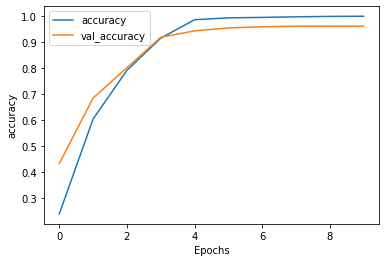

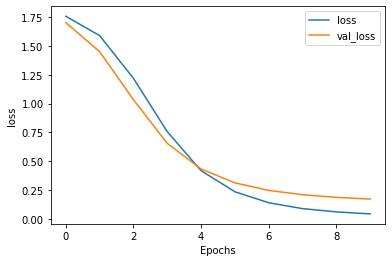

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#Comments: above code example showing the ad-hoc DS way prototyping the problem solving process
# assuming this is the code shared by a DS to MLE, what needed and how to refactor the code to make the solution production ready?

#TODOs: add: 
requirement.txt for the libs

conf.yaml for enviroment
package the solution

refactoring the ML code into

    data_preprocess()
    model_train()
    model_save()
    model_validate()
    model_deploy()

adding testing for each steps

add CICD pipleline